In [15]:
import backtrader as bt
import yfinance as yf
import datetime

def fetch_data(stock_symbol, start_date, end_date):
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    return stock_data



In [27]:

# use MACD strategy as an example 

class MACDStrategy(bt.Strategy):
    params = (
        ('macd1', 10),
        ('macd2', 50),
        ('macdsignal', 9),
    )

    def __init__(self):
        self.macd = bt.indicators.MACD(self.data.close, 
                                       period_me1=self.p.macd1, 
                                       period_me2=self.p.macd2, 
                                       period_signal=self.p.macdsignal)
        self.traded_volume = 0

    def notify_order(self, order):
        if order.status == order.Completed:
            self.traded_volume += abs(order.executed.size) * order.executed.price

    def next(self):
        if self.macd.macd[0] > self.macd.signal[0] and self.macd.macd[-1] <= self.macd.signal[-1]:
            self.buy(size=100)
        elif self.macd.macd[0] < self.macd.signal[0] and self.macd.macd[-1] >= self.macd.signal[-1]:
            self.sell(size=100)



In [28]:

def annualized_rate_of_return(initial_value, final_value, start_date, end_date):
    delta_time = end_date - start_date
    years = delta_time.days / 360 
    return (final_value / initial_value) ** (1/years) - 1

def print_analytics(results, start_date, end_date):
    final_value = results[0].broker.getvalue()
    initial_value = start_cash
    ann_return = annualized_rate_of_return(initial_value, final_value, start_date, end_date)
    
    print('Annualized Rate of Return: {:.2f}%'.format(ann_return*100))
    print('Sharpe Ratio:', results[0].analyzers.sharpe.get_analysis()['sharperatio'])
    print('Max Drawdown:', results[0].analyzers.drawdown.get_analysis()['max']['drawdown'])
    #turnover rate

def run_backtest(data, start_date, end_date):
    cerebro = bt.Cerebro()
    cerebro.addstrategy(MACDStrategy)
    cerebro.broker.set_cash(start_cash)
    cerebro.broker.setcommission(commission=0.002)

    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    
    cerebro.adddata(data)
    results = cerebro.run()
    print_analytics(results, start_date, end_date)
    return results





[*********************100%***********************]  1 of 1 completed
Running In-sample data from 2014-2020

Annualized Rate of Return: -0.21%
Sharpe Ratio: -1.6995762085154598
Max Drawdown: 2.0148852780066178

[*********************100%***********************]  1 of 1 completed

Running Out-of-sample data from 2020-2023

Annualized Rate of Return: 1.78%
Sharpe Ratio: 0.35691227679978405
Max Drawdown: 3.71569000795059



<IPython.core.display.Javascript object>


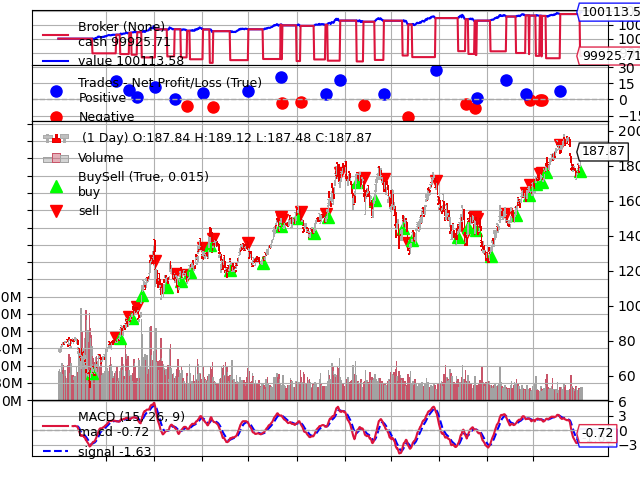

[[<Figure size 640x480 with 5 Axes>]]

In [29]:


stock_symbol = 'AAPL'
start_cash = 100000
start_date_inSample = datetime.datetime(2014, 1, 4)
end_date_inSamlple = datetime.datetime(2019, 12, 31)

data_df_in_sample = fetch_data(stock_symbol, start_date_inSample, end_date_inSamlple)
data_in_sample = bt.feeds.PandasData(dataname=data_df_in_sample)
print("Running In-sample data from 2014-2020")
print("")
run_backtest(data_in_sample, start_date_inSample, end_date_inSamlple)
print("")


start_date_outSample = datetime.datetime(2020, 1, 1)
end_date_outSample = datetime.datetime(2023, 9, 1)

data_df_out_of_sample = fetch_data(stock_symbol, start_date_outSample, end_date_outSample)
data_out_of_sample = bt.feeds.PandasData(dataname=data_df_out_of_sample)
print("\nRunning Out-of-sample data from 2020-2023")
print("")
run_backtest(data_out_of_sample, start_date_outSample, end_date_outSample)
print("")

cerebro.plot(style='candlestick')